Some ideas to explore:

> * Various relationships between movie budget, revenues, genres, ratings, release date, production company, and language.
> * How have budgets and revenues for movies changed over time? 
> * Are there relationships between the budget for a movie and how much revenue it generates? 
> * Do certain genres of movies generate more revenue than others? Higher ratings than others?
> * Does runtime impact budget, revenue, or rating?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
import seaborn as sns
import math
from pandas.plotting import scatter_matrix
import statsmodels.api as sm
import scipy.stats as stats

In [2]:
movies_meta = pd.read_csv('./archive/movies_metadata.csv')
movies_meta.head(2)

/Users/coxem/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [3]:
movies_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

#### Adult

In [4]:
movies_meta['adult'].describe()

count     45466
unique        5
top       False
freq      45454
Name: adult, dtype: object

Most are not 'Adult' movies. Get rid of rows that have adult == 'True'

In [5]:
movies_meta['adult'][0]

'False'

In [6]:
movies_meta = movies_meta[movies_meta['adult'] == 'False']
movies_meta.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [7]:
movies_meta['adult'].describe()

count     45454
unique        1
top       False
freq      45454
Name: adult, dtype: object

I can leave the adult column out

#### Belongs to Collection

In [8]:
movies_meta['belongs_to_collection'].describe()

count                                                  4491
unique                                                 1695
top       {'id': 415931, 'name': 'The Bowery Boys', 'pos...
freq                                                     29
Name: belongs_to_collection, dtype: object

Seeing what movies belong to a franchise could be interesting, leave in but clean up

In [9]:
def literal_return(val):
    try:
        return literal_eval(val)
    except (ValueError, SyntaxError) as e:
        return val

def df_str_to_literal(df, column_name):
    df[column_name] = df[column_name].apply(literal_return)
    return df[column_name]

def dict_name_cleaner(d):
    if isinstance(d, dict):
        return [d['name']]
    return []

def name_cleaner(list_of_dicts):
    if isinstance(list_of_dicts, list):
        return [d['name'] for d in list_of_dicts]
    #Return empty list in case of missing/malformed data
    return []

def countries_cleaner(list_of_dicts):
    if isinstance(list_of_dicts, list):
        return [d['iso_3166_1'] for d in list_of_dicts]
    return []

def language_cleaner(list_of_dicts):
    if isinstance(list_of_dicts, list):
        return [d['iso_639_1'] for d in list_of_dicts]
    return []

In [10]:
collection_df = pd.DataFrame(movies_meta['belongs_to_collection'])
collection_df

,belongs_to_collection
0,"{'id': 10194, 'name': 'Toy Story Collection', ..."
1,NaN
2,"{'id': 119050, 'name': 'Grumpy Old Men Collect..."
3,NaN
4,"{'id': 96871, 'name': 'Father of the Bride Col..."
...,...
45461,NaN
45462,NaN
45463,NaN
45464,NaN


In [11]:
collection_df['belongs_to_collection'][0]

"{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}"

In [12]:
collections_lists = df_str_to_literal(df = collection_df, column_name = 'belongs_to_collection').map(dict_name_cleaner)
collections_lists

0                  [Toy Story Collection]
1                                      []
2             [Grumpy Old Men Collection]
3                                      []
4        [Father of the Bride Collection]
                       ...               
45461                                  []
45462                                  []
45463                                  []
45464                                  []
45465                                  []
Name: belongs_to_collection, Length: 45454, dtype: object

In [13]:
movies_meta['belongs_to_collection'] = collections_lists
movies_meta['belongs_to_collection']

0                  [Toy Story Collection]
1                                      []
2             [Grumpy Old Men Collection]
3                                      []
4        [Father of the Bride Collection]
                       ...               
45461                                  []
45462                                  []
45463                                  []
45464                                  []
45465                                  []
Name: belongs_to_collection, Length: 45454, dtype: object

In [14]:
def get_counts_df(df, column):
    column_df = pd.DataFrame(df[column])
    column_counts = column_df[column].explode().value_counts()
    column_counts_df = column_counts.to_frame('counts').reset_index()
    column_counts_df = column_counts_df.rename(columns = {'index': column})
    
    return column_counts_df

In [15]:
get_counts_df(movies_meta, 'belongs_to_collection')

,belongs_to_collection,counts
0,The Bowery Boys,29
1,Totò Collection,27
2,Zatôichi: The Blind Swordsman,26
3,James Bond Collection,26
4,The Carry On Collection,25
...,...,...
1690,Black Magic Collection,1
1691,Ur kärlekens språk,1
1692,Cirque du Soleil Collection,1
1693,Alan Davies Collection,1


#### Budget

In [16]:
movies_meta['budget'].describe()

count     45454
unique     1223
top           0
freq      36565
Name: budget, dtype: object

In [17]:
movies_meta['budget'][0]

'30000000'

In [18]:
def budget_cleaner(string):
    if string.isnumeric():
        val = int(string)
        return val
    
    return 0

In [19]:
movies_meta['budget'] = movies_meta['budget'].map(budget_cleaner)
movies_meta['budget'].head()

0    30000000
1    65000000
2           0
3    16000000
4           0
Name: budget, dtype: int64

In [20]:
movies_meta['budget'].describe()

count    4.545400e+04
mean     4.225399e+06
std      1.742576e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.800000e+08
Name: budget, dtype: float64

#### Genres

In [21]:
movies_meta['genres'].describe()

count                             45454
unique                             4066
top       [{'id': 18, 'name': 'Drama'}]
freq                               5000
Name: genres, dtype: object

In [22]:
movies_meta['genres'][0]

"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

In [23]:
genres_df = pd.DataFrame(movies_meta['genres'])
genres_df

,genres
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,"[{'id': 35, 'name': 'Comedy'}]"
...,...
45461,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n..."
45462,"[{'id': 18, 'name': 'Drama'}]"
45463,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam..."
45464,[]


In [24]:
genres_lists = df_str_to_literal(df = genres_df, column_name = 'genres').map(name_cleaner)
genres_lists

0         [Animation, Comedy, Family]
1        [Adventure, Fantasy, Family]
2                   [Romance, Comedy]
3            [Comedy, Drama, Romance]
4                            [Comedy]
                     ...             
45461                 [Drama, Family]
45462                         [Drama]
45463       [Action, Drama, Thriller]
45464                              []
45465                              []
Name: genres, Length: 45454, dtype: object

In [25]:
movies_meta['genres'] = genres_lists
movies_meta['genres'].head(2)

0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
Name: genres, dtype: object

#### Homepage

In [26]:
movies_meta['homepage'].describe()

count                            7777
unique                           7668
top       http://www.georgecarlin.com
freq                               12
Name: homepage, dtype: object

I don't think I'll be using this column

#### Id and IMDBid

I'll leave those in in case I want to merge or scrape any additional information

#### Original Language and Original Title

I also don't really care about the original language or original title - I'll use spoken languages and title columns instead

#### Overview

Not going to do NLP, so don't need overview column

#### Popularity

Seems potentially useful

    From TMDB Popularity Score:
        Model for Popularity for Movies:
            Number of votes for the day
            Number of views for the day
            Number of users who marked it as a "favourite" for the day
            Number of users who added it to their "watchlist" for the day
            Release date
            Number of total votes
            Previous days score

In [27]:
movies_meta['popularity'].describe()

count     45451
unique    44166
top         0.0
freq         34
Name: popularity, dtype: object

Hmmm... doesn't seem like popularity is actually a float

In [28]:
movies_meta['popularity'][0]

21.946943

In [29]:
np.asarray(movies_meta['popularity'])

array([21.946943, 17.015539, 11.7129, ..., '0.903007', '0.003503',
       '0.163015'], dtype=object)

There, we go - there are strings in the column

In [30]:
movies_meta['popularity'] = pd.to_numeric(movies_meta['popularity'], downcast = 'float')

In [31]:
movies_meta['popularity'].describe()

count    45451.000000
mean         2.921740
std          6.005887
min          0.000000
25%          0.385944
50%          1.127613
75%          3.679334
max        547.488281
Name: popularity, dtype: float64

#### Poster path

Not doing anything with the posters, so I can leave it out

### Production Companies and Countries Cleaning

In [32]:
prod_companies_df = pd.DataFrame(movies_meta['production_companies'])
prod_countries_df = pd.DataFrame(movies_meta['production_countries'])

#### Production Companies

In [33]:
prod_companies_df['production_companies'][0]

"[{'name': 'Pixar Animation Studios', 'id': 3}]"

In [34]:
prod_companies_lists = df_str_to_literal(df = prod_companies_df, column_name = 'production_companies').map(name_cleaner)
prod_companies_lists

0                                [Pixar Animation Studios]
1        [TriStar Pictures, Teitler Film, Interscope Co...
2                           [Warner Bros., Lancaster Gate]
3                 [Twentieth Century Fox Film Corporation]
4             [Sandollar Productions, Touchstone Pictures]
                               ...                        
45461                                                   []
45462                                        [Sine Olivia]
45463                            [American World Pictures]
45464                                          [Yermoliev]
45465                                                   []
Name: production_companies, Length: 45454, dtype: object

In [35]:
movies_meta['production_companies'] = prod_companies_lists
movies_meta['production_companies'].head() 

0                            [Pixar Animation Studios]
1    [TriStar Pictures, Teitler Film, Interscope Co...
2                       [Warner Bros., Lancaster Gate]
3             [Twentieth Century Fox Film Corporation]
4         [Sandollar Productions, Touchstone Pictures]
Name: production_companies, dtype: object

In [36]:
movies_meta['production_companies'].head() 

0                            [Pixar Animation Studios]
1    [TriStar Pictures, Teitler Film, Interscope Co...
2                       [Warner Bros., Lancaster Gate]
3             [Twentieth Century Fox Film Corporation]
4         [Sandollar Productions, Touchstone Pictures]
Name: production_companies, dtype: object

#### Production Countries

In [37]:
prod_countries_df['production_countries'][0]

"[{'iso_3166_1': 'US', 'name': 'United States of America'}]"

In [38]:
prod_countries_lists = df_str_to_literal(df = prod_countries_df, column_name = 'production_countries').map(name_cleaner)
prod_countries_lists

0        [United States of America]
1        [United States of America]
2        [United States of America]
3        [United States of America]
4        [United States of America]
                    ...            
45461                        [Iran]
45462                 [Philippines]
45463    [United States of America]
45464                      [Russia]
45465              [United Kingdom]
Name: production_countries, Length: 45454, dtype: object

In [39]:
prod_countries_df['production_countries'][0]

[{'iso_3166_1': 'US', 'name': 'United States of America'}]

In [40]:
prod_countries_df['country_iso'] = prod_countries_df['production_countries'].map(countries_cleaner)
prod_countries_df

,production_countries,country_iso
0,"[{'iso_3166_1': 'US', 'name': 'United States o...",[US]
1,"[{'iso_3166_1': 'US', 'name': 'United States o...",[US]
2,"[{'iso_3166_1': 'US', 'name': 'United States o...",[US]
3,"[{'iso_3166_1': 'US', 'name': 'United States o...",[US]
4,"[{'iso_3166_1': 'US', 'name': 'United States o...",[US]
...,...,...
45461,"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",[IR]
45462,"[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",[PH]
45463,"[{'iso_3166_1': 'US', 'name': 'United States o...",[US]
45464,"[{'iso_3166_1': 'RU', 'name': 'Russia'}]",[RU]


In [41]:
prod_countries_df['production_countries'] = prod_countries_lists
prod_countries_df

,production_countries,country_iso
0,[United States of America],[US]
1,[United States of America],[US]
2,[United States of America],[US]
3,[United States of America],[US]
4,[United States of America],[US]
...,...,...
45461,[Iran],[IR]
45462,[Philippines],[PH]
45463,[United States of America],[US]
45464,[Russia],[RU]


In [42]:
movies_meta['production_countries'] = prod_countries_lists
movies_meta['production_country_iso'] = prod_countries_df['country_iso']
movies_meta['production_countries'].head(2)

0    [United States of America]
1    [United States of America]
Name: production_countries, dtype: object

In [43]:
movies_meta['production_country_iso'].head(2)

0    [US]
1    [US]
Name: production_country_iso, dtype: object

#### Release Date

I will definitely want to keep release date, and probably separate it out into Month and Year

In [44]:
movies_meta['release_date'][0]

'1995-10-30'

In [45]:
movies_meta['release_date'] = pd.to_datetime(movies_meta['release_date'], errors='coerce')
movies_meta['release_date'].head()

0   1995-10-30
1   1995-12-15
2   1995-12-22
3   1995-12-22
4   1995-02-10
Name: release_date, dtype: datetime64[ns]

In [46]:
movies_meta['year'] = pd.DatetimeIndex(movies_meta['release_date']).year.fillna(0)
movies_meta['year'].head(2)

0    1995.0
1    1995.0
Name: year, dtype: float64

In [47]:
movies_meta['year'].describe()

count    45454.000000
mean      1988.111101
std         89.835076
min          0.000000
25%       1978.000000
50%       2001.000000
75%       2010.000000
max       2020.000000
Name: year, dtype: float64

In [48]:
movies_meta['year'] = movies_meta['year'].map(math.floor)
movies_meta['year']

0        1995
1        1995
2        1995
3        1995
4        1995
         ... 
45461       0
45462    2011
45463    2003
45464    1917
45465    2017
Name: year, Length: 45454, dtype: int64

In [49]:
movies_meta['month'] = pd.DatetimeIndex(movies_meta['release_date']).month.fillna(0)
movies_meta['month'] = movies_meta['month'].map(math.floor)
movies_meta['month']

0        10
1        12
2        12
3        12
4         2
         ..
45461     0
45462    11
45463     8
45464    10
45465     6
Name: month, Length: 45454, dtype: int64

In [50]:
movies_meta['day'] = pd.DatetimeIndex(movies_meta['release_date']).day_name().fillna(0)
movies_meta['day']

0          Monday
1          Friday
2          Friday
3          Friday
4          Friday
           ...   
45461           0
45462    Thursday
45463      Friday
45464      Sunday
45465      Friday
Name: day, Length: 45454, dtype: object

#### Revenue

Obviously, a very important column

In [51]:
movies_meta['revenue'] = movies_meta['revenue'].fillna(0)
movies_meta['revenue'] = movies_meta['revenue'].map(math.floor)
movies_meta['revenue']

0        373554033
1        262797249
2                0
3         81452156
4         76578911
           ...    
45461            0
45462            0
45463            0
45464            0
45465            0
Name: revenue, Length: 45454, dtype: int64

In [52]:
movies_meta['revenue'].describe()

count    4.545400e+04
mean     1.121083e+07
std      6.433636e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.787965e+09
Name: revenue, dtype: float64

#### Runtime

I am interested in this column

In [53]:
movies_meta['runtime'].fillna(0)
movies_meta['runtime']

0         81.0
1        104.0
2        101.0
3        127.0
4        106.0
         ...  
45461     90.0
45462    360.0
45463     90.0
45464     87.0
45465     75.0
Name: runtime, Length: 45454, dtype: float64

#### Languages

In [54]:
spoken_language_df = pd.DataFrame(movies_meta['spoken_languages'])

In [55]:
spoken_language_df['spoken_languages'][0]

"[{'iso_639_1': 'en', 'name': 'English'}]"

In [56]:
spoken_languages_lists = df_str_to_literal(df = spoken_language_df, column_name = 'spoken_languages').map(name_cleaner)
spoken_languages_lists

0                  [English]
1        [English, Français]
2                  [English]
3                  [English]
4                  [English]
                ...         
45461                [فارسی]
45462                     []
45463              [English]
45464                     []
45465              [English]
Name: spoken_languages, Length: 45454, dtype: object

In [57]:
spoken_language_df['language_iso'] = df_str_to_literal(df = spoken_language_df, column_name = 'spoken_languages').map(language_cleaner)

In [58]:
spoken_language_df['spoken_languages'] = spoken_languages_lists

In [59]:
movies_meta['spoken_languages'] = spoken_languages_lists
movies_meta['language_iso'] = spoken_language_df['language_iso']
movies_meta.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,tagline,title,video,vote_average,vote_count,production_country_iso,year,month,day,language_iso
0,False,[Toy Story Collection],30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,NaN,Toy Story,False,7.7,5415.0,[US],1995,10,Monday,[en]
1,False,[],65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,[US],1995,12,Friday,"[en, fr]"


#### Status

In [60]:
movies_meta['status'].describe()

count        45370
unique           6
top       Released
freq         45006
Name: status, dtype: object

I only want Released

In [61]:
movies_meta['status'][0]

'Released'

In [62]:
movies_meta = movies_meta[movies_meta['status'] == 'Released']
movies_meta['status'].head(2)

0    Released
1    Released
Name: status, dtype: object

Can leave status out now

#### Tagline

Can leave out, not doing NLP

#### Title

In [63]:
movies_meta['title'].describe()

count          45006
unique         41881
top       Cinderella
freq              11
Name: title, dtype: object

In [64]:
movies_meta['title'][0]

'Toy Story'

Leave in

#### Video

In [65]:
movies_meta['video'].describe()

count     45006
unique        2
top       False
freq      44913
Name: video, dtype: object

In [66]:
movies_meta['video'][0]

False

Most are False, I'll remove the ones that are True

In [67]:
movies_meta = movies_meta[movies_meta['video'] == False]
movies_meta['video'].head(2)

0    False
1    False
Name: video, dtype: object

Can leave video out now

#### Vote_average and Vote Count

In [68]:
movies_meta['vote_average'].describe()

count    44913.000000
mean         5.625750
std          1.912365
min          0.000000
25%          5.000000
50%          6.000000
75%          6.800000
max         10.000000
Name: vote_average, dtype: float64

In [69]:
movies_meta['vote_count'].describe()

count    44913.000000
mean       111.121836
std        494.159238
min          0.000000
25%          3.000000
50%         10.000000
75%         35.000000
max      14075.000000
Name: vote_count, dtype: float64

I'll leave these in for now

## Condensing Dataset

In [70]:
movies_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44913 entries, 0 to 45465
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   adult                   44913 non-null  object        
 1   belongs_to_collection   44913 non-null  object        
 2   budget                  44913 non-null  int64         
 3   genres                  44913 non-null  object        
 4   homepage                7676 non-null   object        
 5   id                      44913 non-null  object        
 6   imdb_id                 44898 non-null  object        
 7   original_language       44903 non-null  object        
 8   original_title          44913 non-null  object        
 9   overview                43998 non-null  object        
 10  popularity              44913 non-null  float32       
 11  poster_path             44542 non-null  object        
 12  production_companies    44913 non-null  object

In [71]:
movies_condensed = movies_meta[['belongs_to_collection', 'budget', 'genres', 'id', 'imdb_id', 'popularity', 'production_companies', 'production_countries','release_date','revenue', 'runtime', 'spoken_languages','title','vote_average','vote_count','production_country_iso','year','month', 'day', 'language_iso']]

In [72]:
movies_condensed.head()

,belongs_to_collection,budget,genres,id,imdb_id,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,production_country_iso,year,month,day,language_iso
0,[Toy Story Collection],30000000,"[Animation, Comedy, Family]",862,tt0114709,21.946943,[Pixar Animation Studios],[United States of America],1995-10-30,373554033,81.0,[English],Toy Story,7.7,5415.0,[US],1995,10,Monday,[en]
1,[],65000000,"[Adventure, Fantasy, Family]",8844,tt0113497,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249,104.0,"[English, Français]",Jumanji,6.9,2413.0,[US],1995,12,Friday,"[en, fr]"
2,[Grumpy Old Men Collection],0,"[Romance, Comedy]",15602,tt0113228,11.712900,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,0,101.0,[English],Grumpier Old Men,6.5,92.0,[US],1995,12,Friday,[en]
3,[],16000000,"[Comedy, Drama, Romance]",31357,tt0114885,3.859495,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,81452156,127.0,[English],Waiting to Exhale,6.1,34.0,[US],1995,12,Friday,[en]
4,[Father of the Bride Collection],0,[Comedy],11862,tt0113041,8.387519,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995-02-10,76578911,106.0,[English],Father of the Bride Part II,5.7,173.0,[US],1995,2,Friday,[en]


There are missing values in budget and revenue columns, and I only really want to see the movies for which these data are available.

In [73]:
movies_condensed = movies_condensed.loc[(movies_condensed['budget'] > 0) & (movies_condensed['revenue'] > 0)]
movies_condensed

,belongs_to_collection,budget,genres,id,imdb_id,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,production_country_iso,year,month,day,language_iso
0,[Toy Story Collection],30000000,"[Animation, Comedy, Family]",862,tt0114709,21.946943,[Pixar Animation Studios],[United States of America],1995-10-30,373554033,81.0,[English],Toy Story,7.7,5415.0,[US],1995,10,Monday,[en]
1,[],65000000,"[Adventure, Fantasy, Family]",8844,tt0113497,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249,104.0,"[English, Français]",Jumanji,6.9,2413.0,[US],1995,12,Friday,"[en, fr]"
3,[],16000000,"[Comedy, Drama, Romance]",31357,tt0114885,3.859495,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,81452156,127.0,[English],Waiting to Exhale,6.1,34.0,[US],1995,12,Friday,[en]
5,[],60000000,"[Action, Crime, Drama, Thriller]",949,tt0113277,17.924927,"[Regency Enterprises, Forward Pass, Warner Bros.]",[United States of America],1995-12-15,187436818,170.0,"[English, Español]",Heat,7.7,1886.0,[US],1995,12,Friday,"[en, es]"
8,[],35000000,"[Action, Adventure, Thriller]",9091,tt0114576,5.231580,"[Universal Pictures, Imperial Entertainment, S...",[United States of America],1995-12-22,64350171,106.0,[English],Sudden Death,5.5,174.0,[US],1995,12,Friday,[en]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45250,[],12000000,"[Action, Comedy, Drama]",24049,tt0479751,1.323587,[AVM Productions],[India],2007-06-14,19000000,185.0,"[தமிழ், తెలుగు]",Sivaji: The Boss,6.9,25.0,[IN],2007,6,Thursday,"[ta, te]"
45399,[],750000,"[Crime, Comedy]",280422,tt3805180,0.201582,"[Кинокомпания «Lunapark», Инвада фильм]",[Russia],2014-06-05,3,0.0,[Pусский],All at Once,6.0,4.0,[RU],2014,6,Thursday,[ru]
45409,[],800000,"[Comedy, Drama]",62757,tt0933361,0.903061,[],[],2006-11-23,1328612,100.0,[Pусский],Savages,5.8,6.0,[],2006,11,Thursday,[ru]
45412,[],2000000,"[Romance, Drama]",63281,tt1718881,0.121844,[Profit],[Russia],2010-09-30,1268793,107.0,[Pусский],Pro Lyuboff,4.0,3.0,[RU],2010,9,Thursday,[ru]


In [74]:
movies_condensed['budget'].describe()

count    5.377000e+03
mean     3.111572e+07
std      4.017020e+07
min      1.000000e+00
25%      5.115000e+06
50%      1.700000e+07
75%      4.000000e+07
max      3.800000e+08
Name: budget, dtype: float64

hmm, a budget of 1 doesn't seem right... 

In [75]:
movies_condensed['revenue'].describe()

count    5.377000e+03
mean     9.038159e+07
std      1.661876e+08
min      1.000000e+00
25%      7.022209e+06
50%      2.995000e+07
75%      1.000000e+08
max      2.787965e+09
Name: revenue, dtype: float64

Same for revenue... let's filter until they look more realistic

In [76]:
movies_condensed = movies_condensed.loc[(movies_condensed['budget'] > 5000000) & (movies_condensed['revenue'] > 50000)]
movies_condensed

,belongs_to_collection,budget,genres,id,imdb_id,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,production_country_iso,year,month,day,language_iso
0,[Toy Story Collection],30000000,"[Animation, Comedy, Family]",862,tt0114709,21.946943,[Pixar Animation Studios],[United States of America],1995-10-30,373554033,81.0,[English],Toy Story,7.7,5415.0,[US],1995,10,Monday,[en]
1,[],65000000,"[Adventure, Fantasy, Family]",8844,tt0113497,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249,104.0,"[English, Français]",Jumanji,6.9,2413.0,[US],1995,12,Friday,"[en, fr]"
3,[],16000000,"[Comedy, Drama, Romance]",31357,tt0114885,3.859495,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,81452156,127.0,[English],Waiting to Exhale,6.1,34.0,[US],1995,12,Friday,[en]
5,[],60000000,"[Action, Crime, Drama, Thriller]",949,tt0113277,17.924927,"[Regency Enterprises, Forward Pass, Warner Bros.]",[United States of America],1995-12-15,187436818,170.0,"[English, Español]",Heat,7.7,1886.0,[US],1995,12,Friday,"[en, es]"
8,[],35000000,"[Action, Adventure, Thriller]",9091,tt0114576,5.231580,"[Universal Pictures, Imperial Entertainment, S...",[United States of America],1995-12-22,64350171,106.0,[English],Sudden Death,5.5,174.0,[US],1995,12,Friday,[en]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44842,[Transformers Collection],260000000,"[Action, Science Fiction, Thriller, Adventure]",335988,tt3371366,39.186817,"[Paramount Pictures, Di Bonaventura Pictures, ...",[United States of America],2017-06-21,604942143,149.0,[English],Transformers: The Last Knight,6.2,1440.0,[US],2017,6,Wednesday,[en]
45014,[],60000000,"[Action, Western, Science Fiction, Fantasy, Ho...",353491,tt1648190,50.903591,"[Imagine Entertainment, Weed Road Pictures, Me...","[South Africa, United States of America]",2017-08-03,71000000,95.0,[English],The Dark Tower,5.7,688.0,"[ZA, US]",2017,8,Thursday,[en]
45139,[],50000000,"[Comedy, Family, Animation]",378236,tt4877122,33.694599,"[Columbia Pictures, Sony Pictures Animation]",[United States of America],2017-07-28,66913939,86.0,[English],The Emoji Movie,5.8,327.0,[US],2017,7,Friday,[en]
45167,[],11000000,"[Action, Crime, Mystery, Thriller]",395834,tt5362988,40.796776,"[Thunder Road Pictures, Star Thrower Entertain...","[United Kingdom, United States of America, Can...",2017-08-03,184770205,111.0,[English],Wind River,7.4,181.0,"[GB, US, CA]",2017,8,Thursday,[en]


In [77]:
movies_condensed['popularity'].describe()

count    3993.000000
mean       11.091321
std        15.547481
min         0.000657
25%         6.629999
50%         9.304144
75%        12.521071
max       547.488281
Name: popularity, dtype: float64

In [78]:
movies_condensed['budget'].describe()

count    3.993000e+03
mean     4.103550e+07
std      4.229321e+07
min      5.037000e+06
25%      1.400000e+07
50%      2.500000e+07
75%      5.000000e+07
max      3.800000e+08
Name: budget, dtype: float64

In [79]:
movies_condensed['revenue'].describe()

count    3.993000e+03
mean     1.163914e+08
std      1.846258e+08
min      5.308600e+04
25%      1.692912e+07
50%      5.075234e+07
75%      1.353302e+08
max      2.787965e+09
Name: revenue, dtype: float64

I'm also going to add in a "return" column so I can see how the movie performed compared to the budget

In [80]:
movies_condensed['return'] = movies_condensed['revenue']/movies_condensed['budget']
movies_condensed['return'].describe()

/Users/coxem/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


count    3993.000000
mean        3.020130
std         4.284229
min         0.001134
25%         0.811027
50%         1.936726
75%         3.627306
max        75.520507
Name: return, dtype: float64

In [81]:
movies_condensed.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count,year,month,return
count,3.993000e+03,3993.000000,3.993000e+03,3993.000000,3993.000000,3993.000000,3993.000000,3993.000000,3993.000000
mean,4.103550e+07,11.091321,1.163914e+08,111.711245,6.239669,903.651139,2002.597546,7.027298,3.020130
std,4.229321e+07,15.547481,1.846258e+08,21.110859,0.863748,1389.268886,11.009768,3.380883,4.284229
min,5.037000e+06,0.000657,5.308600e+04,0.000000,0.000000,0.000000,1927.000000,1.000000,0.001134
25%,1.400000e+07,6.629999,1.692912e+07,97.000000,5.700000,138.000000,1997.000000,4.000000,0.811027
50%,2.500000e+07,9.304144,5.075234e+07,108.000000,6.300000,384.000000,2005.000000,7.000000,1.936726
75%,5.000000e+07,12.521071,1.353302e+08,122.000000,6.800000,1022.000000,2011.000000,10.000000,3.627306
max,3.800000e+08,547.488281,2.787965e+09,338.000000,9.100000,14075.000000,2017.000000,12.000000,75.520507


In [82]:
def make_scatter_matrix(df):
    s_matrix = scatter_matrix(df, figsize = (20,20))

    for ax in s_matrix.ravel():
        ax.set_xlabel(ax.get_xlabel(), fontsize = 20, rotation = 45)
        ax.set_ylabel(ax.get_ylabel(), fontsize = 20, rotation = 90)

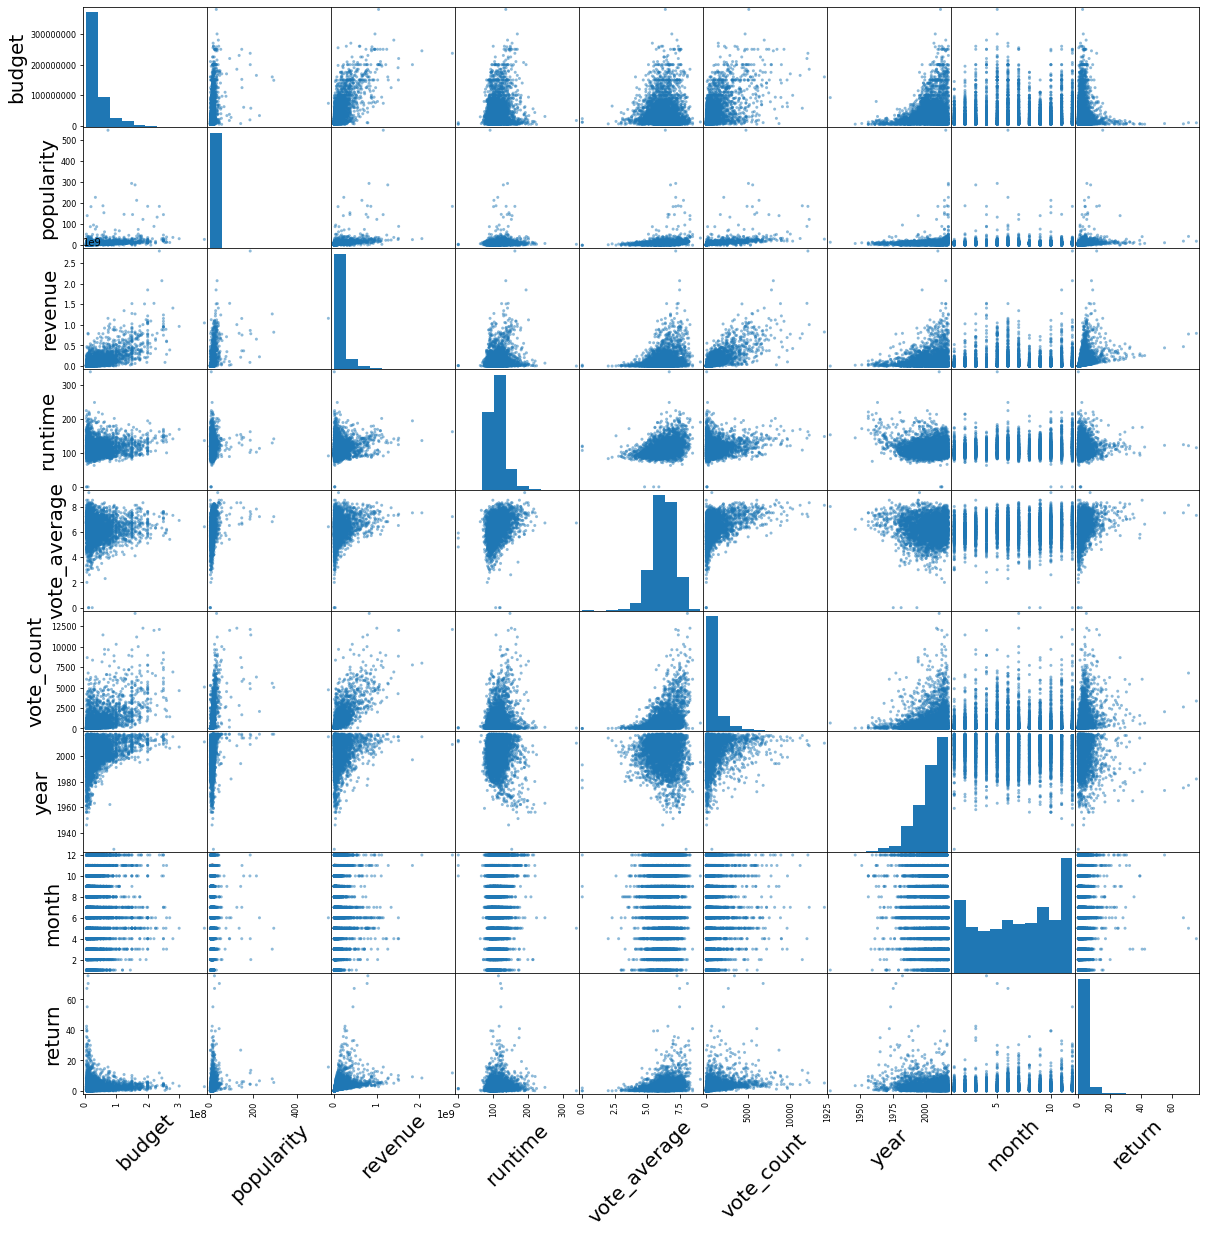

In [83]:
make_scatter_matrix(movies_condensed)

From a glance:
> * Budget
    * Looks like budget has a relatively linear relationship with revenue.
    * It doesn't look like runtime changes much with regards to budget, and it seems that lower budget movies have the largest variation in runtime. 
    * The same could be said with regards to vote average. 
    * On the other hand, it seems more users vote on higher budget movies. 
    * The budget for movies has increased over time, no surprise there, though there is one movie that was made around 1940 and one around 1960 that had higher budgets than other movies made around the same time. 
    * It seems there are certain months where movies where released that had higher budgets - especially concentrated around the summer months, and then another peak in the winter(summer vacation and Holiday movies perhaps). 
    * Most returns are around 0. Most movies seem to not even be breaking even, and the ones that are seem to have much lower budgets.
> * Revenue
    * Runtime doesn't seem to change much with regards to revenue, the largest variation being with low revenue movies.
    * The same could be said with regards to vote average.
    * It seems more users vote on higher revenue movies.
    * The revenue for movies has increased over time, again, no surprise there, though there are some interesting looking outliers.
    * There seems to be a peak for revenue in the summer as well, though not as large as the revenue peak in the winter.
    * Most returns are around 0, the ones that are higher seem to have lower revenue. Maybe I have too many outliers that are clouding this field.
> * Runtime
    * Looks to stay relatively consistent across the board
> * Vote Average
    * Looks to stay relatively consistent across the board
> * Vote Count
    * Already talked about relationship to budget, revenue.
    * More users seem to vote on movies with a runtime between 100 and 200 minutes, which is where most movies fall anyway.
    * The vote averages tend to increase with vote count. It seems users are voting more on movies they like, and not as much on movies they don't like. 
    * Vote count is higher for more recently released movies, not too surprising.

There aren't many linear relationships to explore here, I think the most promising ones are budget and revenue (so an obvious test would be to see if a movie's budget can predict the revenue). But I think I want to explore more features (start with genres).

In [84]:
def model_linear_regression(df, target_col, lst_variable_cols):
    sorted_df = df.sort_values(by = [target_col])
    target = np.array(sorted_df[target_col])
    
    variables_df = sorted_df[lst_variable_cols]
    X = np.array(sm.add_constant(variables_df))
    
    model = sm.OLS(target, X)
    results = model.fit()
    residuals = results.resid
    return X, target, results, residuals

In [85]:
X, target, results, residuals = model_linear_regression(movies_condensed, 'revenue', ['budget', 'popularity'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     2566.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:48:37   Log-Likelihood:                -80016.
No. Observations:                3993   AIC:                         1.600e+05
Df Residuals:                    3990   BIC:                         1.601e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.148e+07   2.84e+06    -11.085      0.000   -3.71e+07   -2.59e+07
x1             2.8164      0.048     59.290      0.000       2.723       2.910
x2          2.912e+06   1.29e+05     22.538      0.000    2.66e+06    3.17e+06
==============================================================================
Omnibus:                     2725.636   Durbin-Watson:                   1.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            90819.966
Skew:                           2.794   Prob(JB):                         0.00
Kurtosis:                      25.686   Cond. No.                     8.66e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.66e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
def plot_predictions_vs_actual(X, target, results, x_label, y_label, actual_label, predict_label):
    betas = np.array(results.params).reshape(-1,1)
    y_p = np.dot(X, betas)
    
    x = np.arange(len(target))
    
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.plot(x, target, label=actual_label)
    ax.plot(x, y_p, c='r',label=predict_label)
    ax.set_xlabel(x_label, fontsize = 20)
    ax.set_ylabel(y_label, fontsize = 20)
    ax.legend();

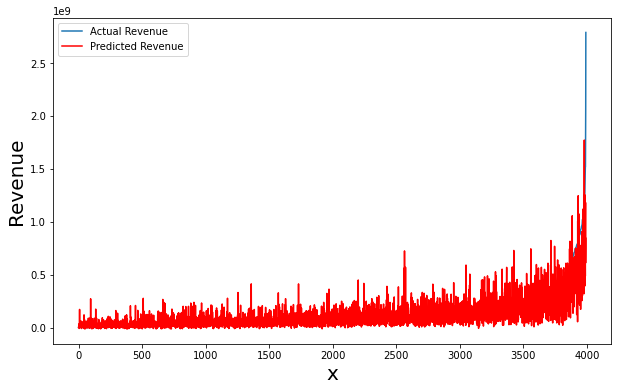

In [87]:
plot_predictions_vs_actual(X, target, results, 
                           'x',
                           'Revenue', 
                           'Actual Revenue', 
                           'Predicted Revenue')

In [88]:
def plot_residuals(X, target, results, residuals, x_label='Predicted', y_label='Residuals'):
    fig, ax = plt.subplots()
    y_predict = results.predict(X)
    #shape = y_predict.shape
    #residuals = y_predict - target.reshape(shape[0],)
    ax.scatter(y_predict, residuals, alpha=0.5)
    ax.axhline(0, color='r', ls='--')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

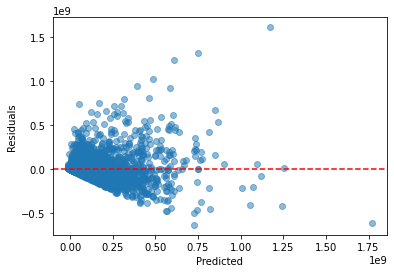

In [89]:
plot_residuals(X, target, results, residuals)

Try plotting log of target, refit model, replot residuals

In [90]:
def qq_plot(X, target, results, title='QQ Plot vs Normal Distribution for Residuals'):
    fig, ax = plt.subplots(figsize = (8, 8))
    y_predict = results.predict(X)
    stats.probplot(target - y_predict, plot=ax)
    ax.set_title(title, fontsize = 18)
    
#fig, axs = plt.subplots(1, 2, figsize=((11,5)))
#predictions = credit_card_model.predict(credit_card)
#stats.probplot(credit_card['AVGEXP'] - predictions, plot=axs[0]);
#axs[0].set_title("QQ Plot vs Normal dist for Credit Card Residuals")

#predictions = credit_card_log_model.predict(credit_card)
#stats.probplot(credit_card['LOGAVGEXP'] - predictions, plot=axs[1]);
#axs[1].set_title("QQ Plot vs Normal dist for Credit Card Log Residuals")

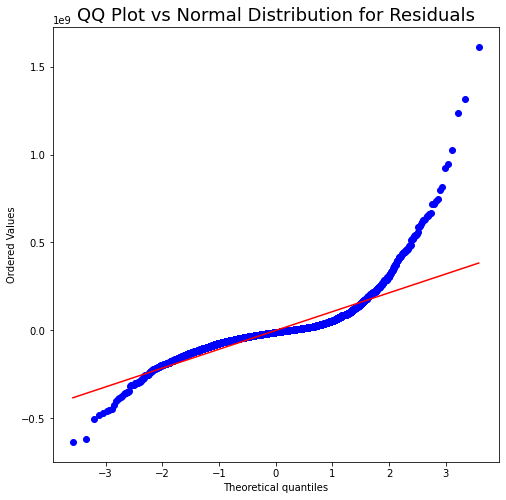

In [91]:
qq_plot(X, target, results)

### Exploring Genres

In [92]:
def get_counts(df, column):
    column_df = pd.DataFrame(df[column])
    column_counts = column_df[column].explode().value_counts()
    column_counts_df = column_counts.to_frame('counts').reset_index()
    column_counts_df = column_counts_df.rename(columns = {'index': column})
    
    return column_counts_df

In [93]:
genres_counts_df = get_counts(movies_condensed, 'genres')
genres_counts_df

,genres,counts
0,Drama,1819
1,Comedy,1400
2,Action,1213
3,Thriller,1179
4,Adventure,850
5,Romance,705
6,Crime,666
7,Science Fiction,523
8,Family,487
9,Fantasy,443


In [94]:
#fig, ax = plt.subplots(figsize = (18, 8))
#x_data = genres_counts_df['genre']
#y_data = genres_counts_df['counts']

#ax.bar(x_data, y_data)

#ax.set_xlabel('Genre', fontsize = 20)
#ax.set_xticklabels(x_data, rotation = 45, fontsize = 20)
#ax.set_ylabel('# of Movies', fontsize = 20)
#ax.set_title('Counts of Movies by Genre', fontsize = 24)

#fig.tight_layout()

In [95]:
def counts_horizontal_bar(df, x_column, y_column, x_min, x_max, x_inc, ax):
    x_data = df[x_column]
    y_data = df[y_column]
    y = np.arange(len(y_data))
    x = np.linspace(x_min, x_max, (x_max-x_min)//x_inc + 1, dtype='int')
    
    ax.barh(y_data, x_data)
    ax.invert_yaxis()
    ax.set_yticks(y)
    ax.set_xticks(x)
    ax.set_xticklabels(x, fontsize = 18, rotation = 45)
    ax.set_yticklabels(y_data, fontsize = 18)
    ax.xaxis.grid(True)
    fig.tight_layout()

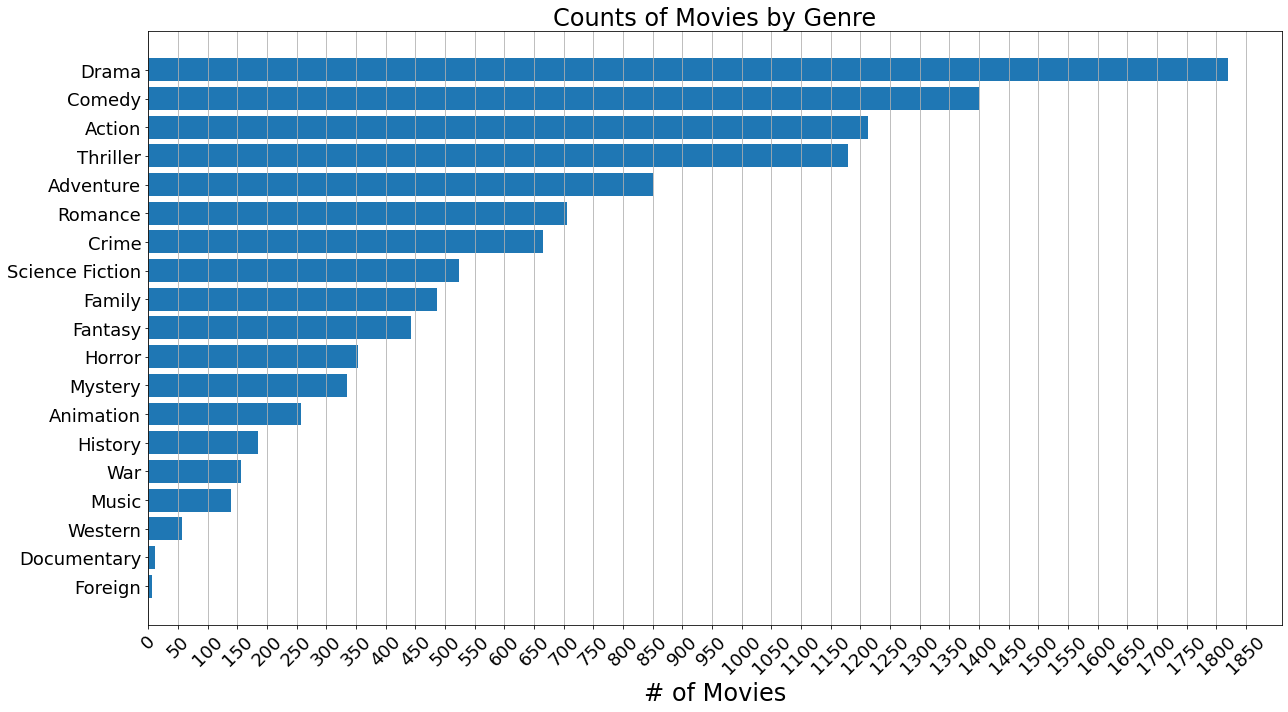

In [97]:
fig, ax = plt.subplots(figsize=(18,10))
ax.set_xlabel('# of Movies', fontsize = 24)
ax.set_title('Counts of Movies by Genre', fontsize = 24)

counts_horizontal_bar(genres_counts_df, 'counts', 'genres', 0, 1850, 50, ax)
#plt.savefig('movie_counts_by_genre.png')

In [82]:
def get_list(df, column):
    lst = df[column].tolist()
    return lst

In [83]:
genres_list = get_list(genres_counts_df, 'genres')
genres_list

['Drama',
 'Comedy',
 'Action',
 'Thriller',
 'Adventure',
 'Romance',
 'Crime',
 'Science Fiction',
 'Family',
 'Fantasy',
 'Horror',
 'Mystery',
 'Animation',
 'History',
 'War',
 'Music',
 'Western',
 'Documentary',
 'Foreign']

In [84]:
def create_bool_columns(df, column_name, list_of_columns):
    for column in list_of_columns:
        df[column] = df[column_name].apply(lambda x: 1 if column in x else 0)

In [85]:
create_bool_columns(df = movies_condensed, column_name = 'genres', list_of_columns = genres_list)

/Users/coxem/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [86]:
movies_condensed.head()

,belongs_to_collection,budget,genres,id,imdb_id,popularity,production_companies,production_countries,release_date,revenue,...,Fantasy,Horror,Mystery,Animation,History,War,Music,Western,Documentary,Foreign
0,[Toy Story Collection],30000000,"[Animation, Comedy, Family]",862,tt0114709,21.9469,[Pixar Animation Studios],[United States of America],1995-10-30,373554033,...,0,0,0,1,0,0,0,0,0,0
1,[],65000000,"[Adventure, Fantasy, Family]",8844,tt0113497,17.0155,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249,...,1,0,0,0,0,0,0,0,0,0
3,[],16000000,"[Comedy, Drama, Romance]",31357,tt0114885,3.85949,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,81452156,...,0,0,0,0,0,0,0,0,0,0
5,[],60000000,"[Action, Crime, Drama, Thriller]",949,tt0113277,17.9249,"[Regency Enterprises, Forward Pass, Warner Bros.]",[United States of America],1995-12-15,187436818,...,0,0,0,0,0,0,0,0,0,0
8,[],35000000,"[Action, Adventure, Thriller]",9091,tt0114576,5.23158,"[Universal Pictures, Imperial Entertainment, S...",[United States of America],1995-12-22,64350171,...,0,0,0,0,0,0,0,0,0,0


In [87]:
def make_genre_specific_df(df, genre):
    return df[df[genre] == 1]

In [88]:
drama = make_genre_specific_df(movies_condensed, 'Drama')
comedy = make_genre_specific_df(movies_condensed, 'Comedy')
thriller = make_genre_specific_df(movies_condensed, 'Thriller')
romance = make_genre_specific_df(movies_condensed, 'Romance')
action = make_genre_specific_df(movies_condensed, 'Action')
horror = make_genre_specific_df(movies_condensed, 'Horror')
crime = make_genre_specific_df(movies_condensed, 'Crime')
documentary = make_genre_specific_df(movies_condensed, 'Documentary')
adventure = make_genre_specific_df(movies_condensed, 'Adventure')
science_fiction = make_genre_specific_df(movies_condensed, 'Science Fiction')
family = make_genre_specific_df(movies_condensed, 'Family')
mystery = make_genre_specific_df(movies_condensed, 'Mystery')
fantasy = make_genre_specific_df(movies_condensed, 'Fantasy')
animation = make_genre_specific_df(movies_condensed, 'Animation')
foreign = make_genre_specific_df(movies_condensed, 'Foreign')
music = make_genre_specific_df(movies_condensed, 'Music')
history = make_genre_specific_df(movies_condensed, 'History')
war = make_genre_specific_df(movies_condensed, 'War')
western = make_genre_specific_df(movies_condensed, 'Western')

In [89]:
drama.describe()

,budget,revenue,runtime,vote_average,vote_count,year,month,return,Drama,Comedy,...,Fantasy,Horror,Mystery,Animation,History,War,Music,Western,Documentary,Foreign
count,1.819000e+03,1.819000e+03,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.0,1819.000000,...,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.0,1819.000000
mean,3.075434e+07,7.746571e+07,119.050027,6.510775,712.431006,2002.642661,7.442551,2.793562,1.0,0.216053,...,0.052226,0.042881,0.097306,0.012644,0.091259,0.063222,0.045629,0.016493,0.0,0.001649
std,2.927019e+07,1.214300e+08,22.670724,0.786754,1175.037384,11.362700,3.440101,4.152636,0.0,0.411664,...,0.222545,0.202644,0.296456,0.111764,0.288056,0.243428,0.208738,0.127395,0.0,0.040589
min,5.037000e+06,5.308600e+04,66.000000,0.000000,0.000000,1927.000000,1.000000,0.003612,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,1.200000e+07,1.182060e+07,104.000000,6.000000,101.000000,1997.000000,4.000000,0.640199,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,2.000000e+07,3.540176e+07,115.000000,6.600000,295.000000,2005.000000,8.000000,1.627632,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,4.000000e+07,9.494144e+07,129.000000,7.000000,794.000000,2011.000000,10.000000,3.274539,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
max,2.500000e+08,1.845034e+09,338.000000,9.100000,12269.000000,2017.000000,12.000000,55.163268,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


In [90]:
def broadcast_and_clean(df, broadcast_col, list_of_columns):
    out_df = df[[broadcast_col] + list_of_columns]
    
    for column in list_of_columns:
        out_df[column] = out_df[column]*out_df[broadcast_col]
    
    out_df = out_df.drop(columns = [broadcast_col])
    out_df = out_df.replace(0.0,np.nan)
    
    return out_df


In [91]:
runtime_genres = broadcast_and_clean(movies_condensed,'runtime', genres_list)

/Users/coxem/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [92]:
def violin_plot_by_genre(data, x_labels, y_label, title):
    sns.set(style='whitegrid')
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_ylabel(y_label, fontsize = 24)
    ax.set_title(title, fontsize = 24)
    plt.yticks(fontsize=20)
    ax.set_xticklabels(x_labels, fontsize = 20, rotation=45)
    sns.violinplot(data=data, ax=ax)
    fig.tight_layout()

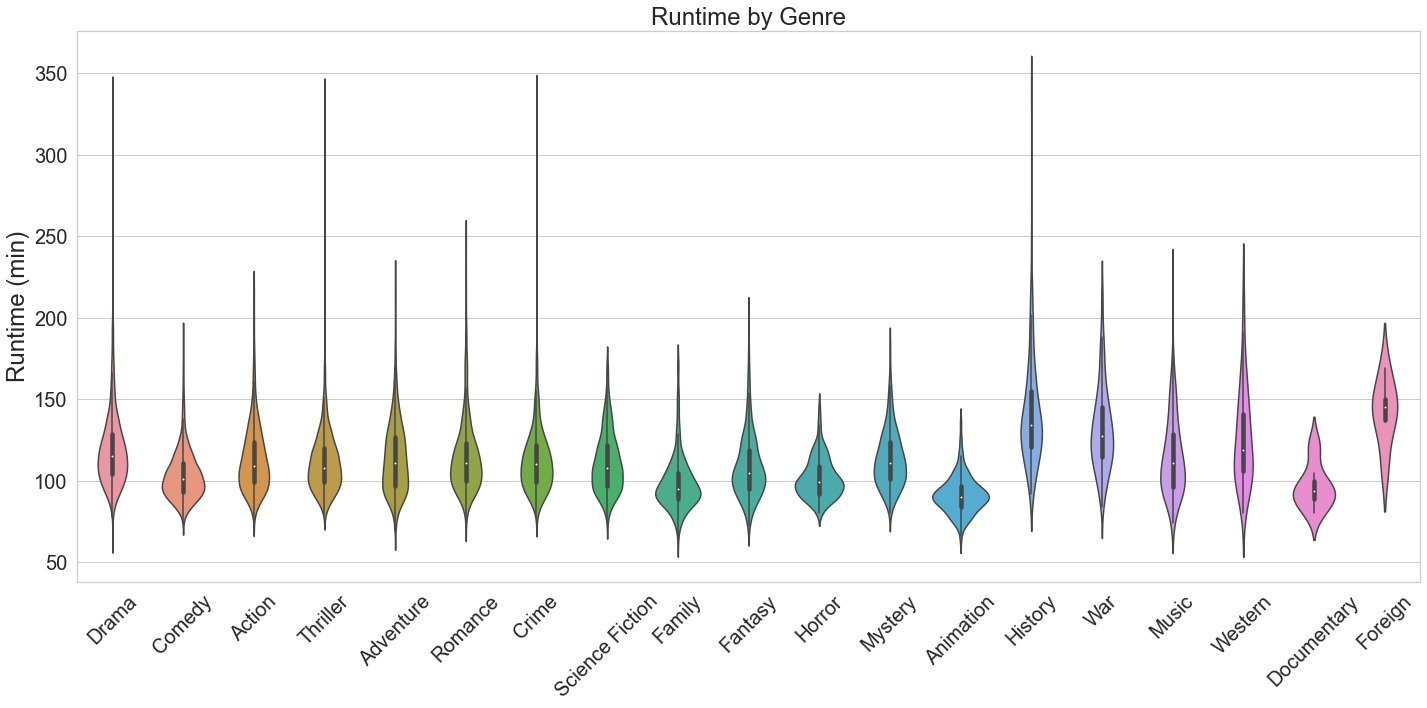

In [93]:
violin_plot_by_genre(runtime_genres, genres_list, 'Runtime (min)', 'Runtime by Genre')

In [106]:
movies_condensed.head()

,belongs_to_collection,budget,genres,id,imdb_id,popularity,production_companies,production_countries,release_date,revenue,...,Fantasy,Horror,Mystery,Animation,History,War,Music,Western,Documentary,Foreign
0,[Toy Story Collection],30000000,"[Animation, Comedy, Family]",862,tt0114709,21.9469,[Pixar Animation Studios],[United States of America],1995-10-30,373554033,...,0,0,0,1,0,0,0,0,0,0
1,[],65000000,"[Adventure, Fantasy, Family]",8844,tt0113497,17.0155,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249,...,1,0,0,0,0,0,0,0,0,0
3,[],16000000,"[Comedy, Drama, Romance]",31357,tt0114885,3.85949,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,81452156,...,0,0,0,0,0,0,0,0,0,0
5,[],60000000,"[Action, Crime, Drama, Thriller]",949,tt0113277,17.9249,"[Regency Enterprises, Forward Pass, Warner Bros.]",[United States of America],1995-12-15,187436818,...,0,0,0,0,0,0,0,0,0,0
8,[],35000000,"[Action, Adventure, Thriller]",9091,tt0114576,5.23158,"[Universal Pictures, Imperial Entertainment, S...",[United States of America],1995-12-22,64350171,...,0,0,0,0,0,0,0,0,0,0


In [107]:
import scipy.stats as stats

In [108]:
movies_condensed[movies_condensed['History'] == 1]['runtime']

13       192.0
108      177.0
188      135.0
231      127.0
360      140.0
         ...  
43165    126.0
43229    140.0
43575    161.0
44557    120.0
44678    107.0
Name: runtime, Length: 184, dtype: float64

Mean runtime for history and animation different?

In [110]:
stats.ttest_ind(movies_condensed[movies_condensed['History'] == 1]['runtime'], movies_condensed[movies_condensed['Animation'] == 1]['runtime'], equal_var = False)

Ttest_indResult(statistic=19.829904883517283, pvalue=2.173526429849459e-50)

In [111]:
stats.normaltest(movies_condensed[movies_condensed['History'] == 1]['runtime'])

NormaltestResult(statistic=93.05328901416235, pvalue=6.219207243369415e-21)

The history genre doesn't appear to be normally distributed

Had to replace 0's with np.nan in order to get the runtime to come out correctly in the violin plot

In [94]:
return_genres = broadcast_and_clean(movies_condensed,'return', genres_list)

/Users/coxem/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


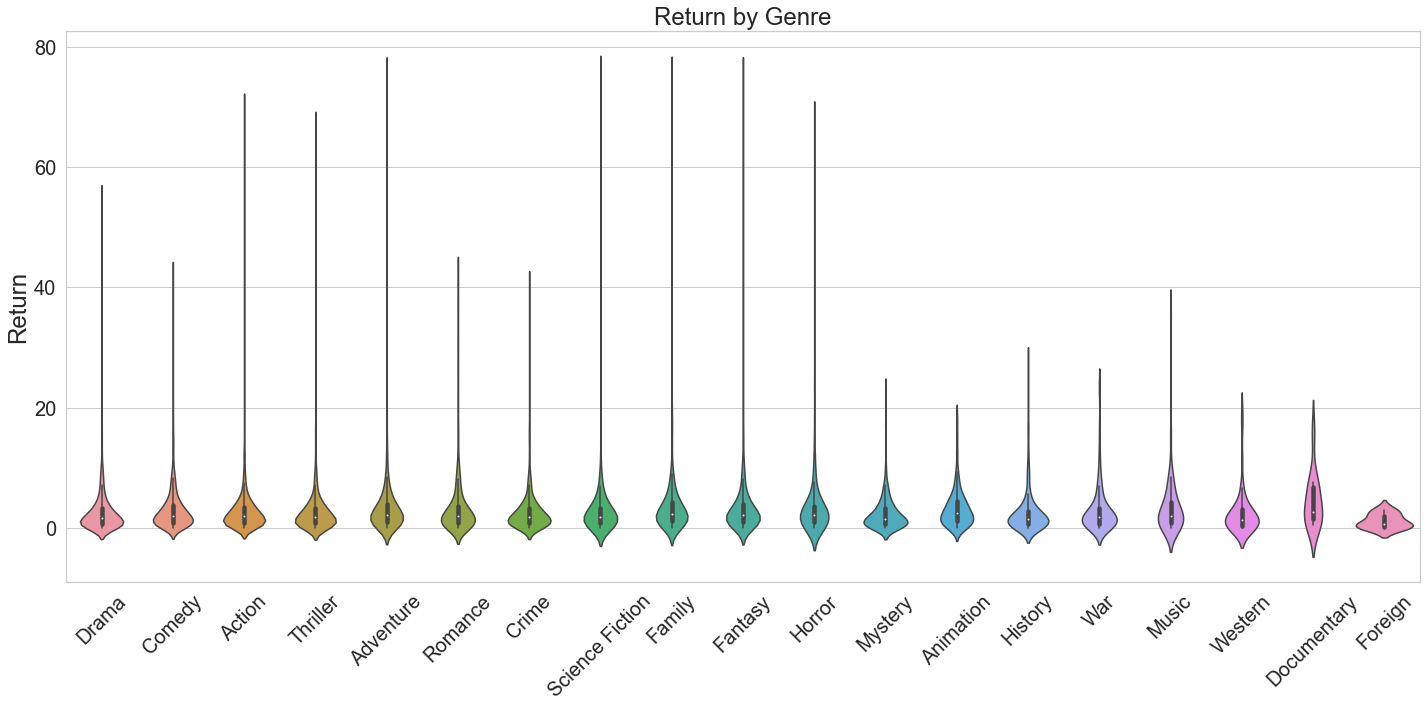

In [95]:
violin_plot_by_genre(return_genres, genres_list, 'Return', 'Return by Genre')

I increased budget until I was able to see clear violin plots. Still have some outliers

In [ ]:
def get_top(df, num, column, list_of_columns):
    out_df = df.nlargest(num, column)
    

In [96]:
top_return = movies_condensed.nlargest(20, 'return')
top_return = top_return[['title','belongs_to_collection', 'budget', 'revenue', 'return','genres']]
top_return

,title,belongs_to_collection,budget,revenue,return,genres
1065,E.T. the Extra-Terrestrial,[],10500000,792965326,75.520507,"[Science Fiction, Adventure, Family, Fantasy]"
256,Star Wars,[Star Wars Collection],11000000,775398007,70.490728,"[Adventure, Action, Science Fiction]"
1338,Jaws,[The Jaws Collection],7000000,470654000,67.236286,"[Horror, Thriller, Adventure]"
1888,The Exorcist,[The Exorcist Collection],8000000,441306145,55.163268,"[Drama, Horror, Thriller]"
352,Four Weddings and a Funeral,[],6000000,254700832,42.450139,"[Comedy, Drama, Romance]"
834,The Godfather,[The Godfather Collection],6000000,245066411,40.844402,"[Drama, Crime]"
4492,Look Who's Talking,[Look Who's Talking Collection],7500000,296000000,39.466667,"[Comedy, Romance]"
24258,Annabelle,[Annabelle Collection],6500000,255273813,39.272894,[Horror]
1056,Dirty Dancing,[Dirty Dancing Collection],6000000,213954274,35.659046,"[Drama, Music, Romance]"
1006,The Sound of Music,[],8200000,286214286,34.904181,"[Drama, Family, Music, Romance]"


In [97]:
return_std = movies_condensed['return'].std()
return_std

4.2842291380083894

In [98]:
return_median = movies_condensed['return'].median()
return_median

1.9367264

In [99]:
movies_wo_return_outliers = movies_condensed[movies_condensed['return'] <= 10]
movies_wo_return_outliers['return'].describe()

count    3833.000000
mean        2.388828
std         2.113093
min         0.001134
25%         0.777419
50%         1.838394
75%         3.353343
max         9.918541
Name: return, dtype: float64

In [100]:
return_genres_wo_outliers = broadcast_and_clean(movies_wo_return_outliers,'return', genres_list)
return_genres_wo_outliers.describe()

/Users/coxem/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Drama,Comedy,Action,Thriller,Adventure,Romance,Crime,Science Fiction,Family,Fantasy,Horror,Mystery,Animation,History,War,Music,Western,Documentary,Foreign
count,1750.000000,1345.000000,1177.000000,1142.000000,813.000000,665.000000,648.000000,510.000000,467.000000,425.000000,334.000000,327.000000,246.000000,177.000000,148.000000,133.000000,54.000000,11.000000,6.000000
mean,2.171166,2.560916,2.341897,2.230527,2.631731,2.436159,2.255207,2.345949,2.787313,2.577997,2.463135,2.152215,2.853551,1.979135,2.291509,2.761193,1.719236,3.555069,1.165868
std,2.113715,2.195878,1.946236,1.970225,2.129260,2.250989,1.978882,2.035934,2.181835,2.149210,2.067689,1.996848,2.244962,1.987099,2.146336,2.563124,1.691728,2.711381,1.204657
min,0.003612,0.001134,0.001134,0.005092,0.003612,0.006024,0.005165,0.003103,0.001134,0.003103,0.008383,0.006049,0.001134,0.003612,0.003612,0.010895,0.016713,0.563677,0.115970
25%,0.617303,0.890378,0.848951,0.729284,0.958173,0.713364,0.781744,0.802119,1.132409,1.000868,0.849165,0.622317,1.023769,0.651239,0.689668,0.751486,0.392532,1.413113,0.240744
50%,1.516438,1.969025,1.879455,1.727651,2.109684,1.807500,1.733577,1.795824,2.224715,2.044539,2.131688,1.431233,2.382577,1.394896,1.649708,1.853682,1.216667,2.726501,0.701943
75%,2.994243,3.594282,3.311459,3.157480,3.721126,3.343242,3.135141,3.162227,4.021047,3.500000,3.303054,3.083574,4.214820,2.670347,2.937562,3.750941,2.391452,6.238730,1.987013
max,9.807692,9.914007,9.908998,9.918541,9.878579,9.797082,9.918541,9.908998,9.852076,9.840416,9.908998,9.918541,9.852076,9.793333,9.532490,9.914007,6.638866,7.572458,2.972973


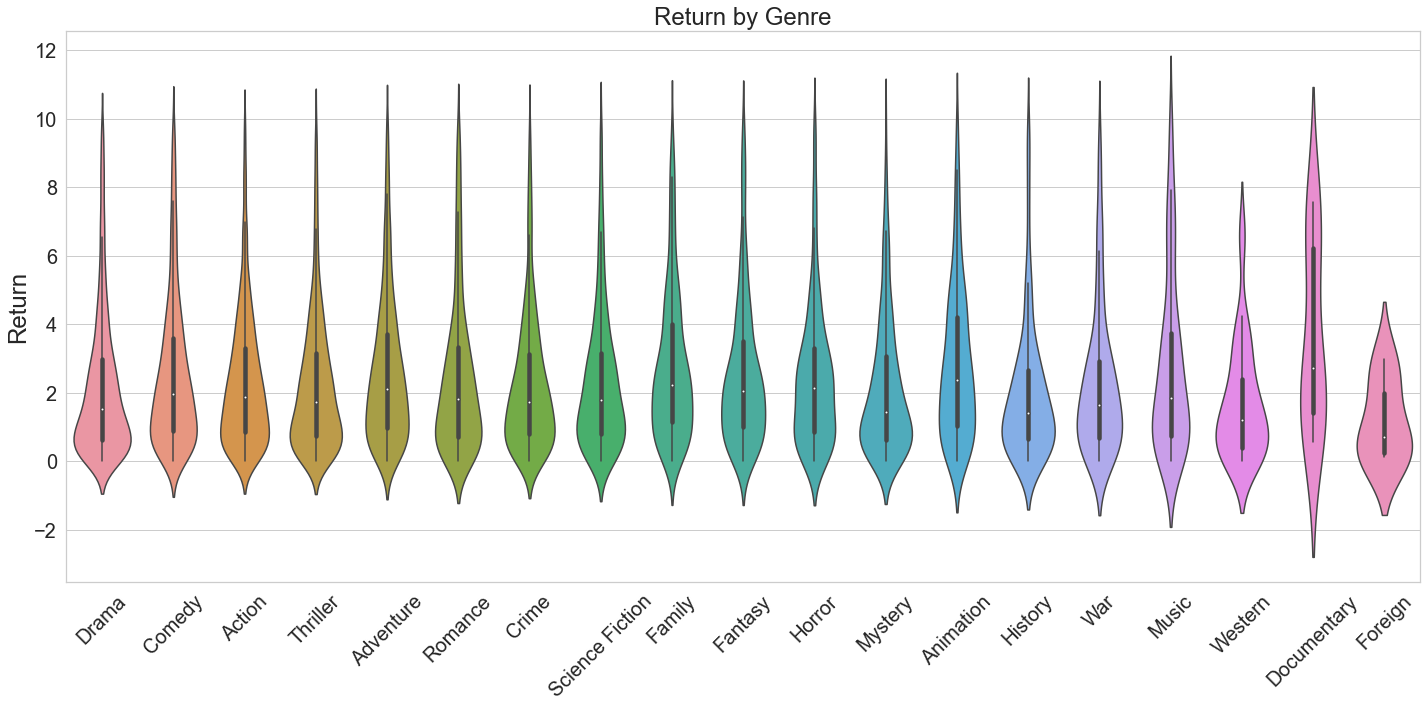

In [101]:
violin_plot_by_genre(return_genres_wo_outliers, genres_list, 'Return', 'Return by Genre')

In [102]:
return_genres_wo_outliers.describe()

,Drama,Comedy,Action,Thriller,Adventure,Romance,Crime,Science Fiction,Family,Fantasy,Horror,Mystery,Animation,History,War,Music,Western,Documentary,Foreign
count,1750.000000,1345.000000,1177.000000,1142.000000,813.000000,665.000000,648.000000,510.000000,467.000000,425.000000,334.000000,327.000000,246.000000,177.000000,148.000000,133.000000,54.000000,11.000000,6.000000
mean,2.171166,2.560916,2.341897,2.230527,2.631731,2.436159,2.255207,2.345949,2.787313,2.577997,2.463135,2.152215,2.853551,1.979135,2.291509,2.761193,1.719236,3.555069,1.165868
std,2.113715,2.195878,1.946236,1.970225,2.129260,2.250989,1.978882,2.035934,2.181835,2.149210,2.067689,1.996848,2.244962,1.987099,2.146336,2.563124,1.691728,2.711381,1.204657
min,0.003612,0.001134,0.001134,0.005092,0.003612,0.006024,0.005165,0.003103,0.001134,0.003103,0.008383,0.006049,0.001134,0.003612,0.003612,0.010895,0.016713,0.563677,0.115970
25%,0.617303,0.890378,0.848951,0.729284,0.958173,0.713364,0.781744,0.802119,1.132409,1.000868,0.849165,0.622317,1.023769,0.651239,0.689668,0.751486,0.392532,1.413113,0.240744
50%,1.516438,1.969025,1.879455,1.727651,2.109684,1.807500,1.733577,1.795824,2.224715,2.044539,2.131688,1.431233,2.382577,1.394896,1.649708,1.853682,1.216667,2.726501,0.701943
75%,2.994243,3.594282,3.311459,3.157480,3.721126,3.343242,3.135141,3.162227,4.021047,3.500000,3.303054,3.083574,4.214820,2.670347,2.937562,3.750941,2.391452,6.238730,1.987013
max,9.807692,9.914007,9.908998,9.918541,9.878579,9.797082,9.918541,9.908998,9.852076,9.840416,9.908998,9.918541,9.852076,9.793333,9.532490,9.914007,6.638866,7.572458,2.972973


In [103]:
top_return = movies_wo_return_outliers.nlargest(20, 'return')
top_return = top_return[['title','belongs_to_collection', 'budget', 'revenue', 'return','genres']]
top_return

,title,belongs_to_collection,budget,revenue,return,genres
46,Se7en,[],33000000,327311859,9.918541,"[Crime, Mystery, Thriller]"
29799,Pitch Perfect 2,[Pitch Perfect Collection],29000000,287506194,9.914007,"[Comedy, Music]"
1158,Aliens,[Alien Collection],18500000,183316455,9.908998,"[Horror, Action, Thriller, Science Fiction]"
1246,Indiana Jones and the Last Crusade,[Indiana Jones Collection],48000000,474171806,9.878579,"[Adventure, Action]"
13848,Ice Age: Dawn of the Dinosaurs,[Ice Age Collection],90000000,886686817,9.852076,"[Animation, Comedy, Family, Adventure]"
2601,Ghostbusters,[Ghostbusters Collection],30000000,295212467,9.840416,"[Comedy, Fantasy]"
39495,Sultan,[],10400000,102000000,9.807692,"[Drama, Action]"
19731,Silver Linings Playbook,[],21000000,205738714,9.797082,"[Drama, Comedy, Romance]"
1242,Ben-Hur,[],15000000,146900000,9.793333,"[Action, Adventure, Drama, History]"
9698,Howl's Moving Castle,[],24000000,234710455,9.779602,"[Fantasy, Animation, Adventure]"


### Exploring Production Companies

In [105]:
company_counts_df = get_counts(movies_condensed, 'production_companies')
company_counts_df

,production_companies,counts
0,Warner Bros.,375
1,Universal Pictures,345
2,Paramount Pictures,280
3,Twentieth Century Fox Film Corporation,260
4,Columbia Pictures,198
...,...,...
4096,The Last Picture Company,1
4097,Casey Productions,1
4098,Havana Nights LLC,1
4099,Dentsu Inc.,1


In [ ]:
#company_list = get_list(company_counts_df, 'production_companies')
#company_list

In [ ]:
company_counts_df = company_counts_df[company_counts_df.counts > 130]
company_counts_df

In [ ]:
fig, ax = plt.subplots(figsize=(18,10))
ax.set_xlabel('# of Movies', fontsize = 24)
ax.set_title('Counts of Movies by Production Company', fontsize = 24)

counts_horizontal_bar(company_counts_df, 'counts', 'production_company', 100, 1300, 50, ax)

### Exploring Production Countries

In [ ]:
countries_counts = prod_countries_lists.explode().value_counts()
countries_counts

In [ ]:
countries_counts_df = countries_counts.to_frame('counts').reset_index().rename(columns = {'index': 'production_country'})
countries_counts_df

In [ ]:
countries_counts_df = countries_counts_df[countries_counts_df.counts > 320]
countries_counts_df

In [ ]:
fig, ax = plt.subplots(figsize=(18,10))
ax.set_xlabel('# of Movies', fontsize = 24)
ax.set_title('Counts of Movies by Production Country', fontsize = 24)

counts_horizontal_bar(countries_counts_df, 'counts', 'production_country', 300, 21200, 1100, ax)

## Ratings CSV

In [ ]:
ratings = pd.read_csv('./archive/ratings.csv')
ratings.head(2)

In [ ]:
ratings.info()

In [ ]:
ratings['movieId'] = ratings['movieId'].apply(str)
ratings.info()

In [ ]:
#movies_ratings = pd.merge(movies_meta, ratings, how='left', left_on=['id'], right_on=['movieId'])
#movies_ratings

In [ ]:
movies_meta['vote_average'].head()

In [ ]:
movies_meta['vote_count'].head()

In [ ]:
ratings_counts = ratings['movieId'].value_counts()
ratings_counts

In [ ]:
ratings_counts = ratings_counts.to_frame('counts').reset_index().rename(columns = {'index': 'movieId'})
ratings_counts

In [ ]:
ratings_counts = ratings_counts[ratings_counts.counts > 999]
ratings_counts

In [ ]:
ratings_counts[ratings_counts.movieId == '356']